<a href="https://colab.research.google.com/github/anandcpanchal/experimental/blob/master/adversarial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NOTE : Load goldfish image in current directory or input image_path

## Classification Inference

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications import ResNet50

In [3]:
def preprocess_input_by_filename( image_name):
  image = cv2.imread(image_name)
  image = cv2.cvtColor( image, cv2.COLOR_BGR2RGB)
  image = cv2.resize( image, (224,224))
  plt.imshow(image)
  image = np.expand_dims( image, axis=0)
  return image

In [4]:
image_path = './goldfish.jpeg'

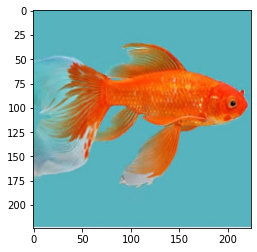

In [5]:
# Preprocessing
image = preprocess_input_by_filename( image_path)

In [6]:
def populate_class_index_dict():
  class_list = decode_predictions(np.expand_dims(np.arange(1000), 0), top=1000)
  class_dict = {}
  for item in class_list[0]:
    class_dict[item[1]] = item[2]
  return class_dict

def get_class_index( class_name):
  class_dict = populate_class_index_dict()
  return class_dict[class_name]

In [7]:
# Load Classifier Model Weights
def load_model():
  return ResNet50(weights='imagenet')

In [8]:
def predict( model, image):
  prediction = model.predict(image)
  class_pred = decode_predictions( prediction, top=5)
  # for ( i, (imagenetID, label, prob)) in enumerate(class_pred[0]):
  #   print("{}. {} \t\t:\t\t {:.2f}%".format(i + 1, label,prob * 100))
  return class_pred[0][0]

# Prediction

In [9]:
resnet = load_model()
result = predict( resnet, image)
print(" Predicted image as : ", result[1], " with confidence : ", result[2], " and classIdx = ", get_class_index(result[1]))

40960/35363 [==================================] - 0s 0us/step
 Predicted image as :  goldfish  with confidence :  0.8512285  and classIdx =  1


#Adversarial Image Generation


In [10]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [11]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow.keras.applications.resnet50 import preprocess_input

In [12]:
def clip_tensor_value( tensor, value):
  return tf.clip_by_value( tensor, clip_value_min= -value, clip_value_max= value)

In [13]:
def generate_adversaries( model, baseImage, delta, classIdx, steps=50):
  for step in range(0,steps):
    with tf.GradientTape() as tape:
      tape.watch(delta)

      adversary = preprocess_input( baseImage + delta)
      predictions = model(adversary, training=False)
      loss = -sccLoss( tf.convert_to_tensor([classIdx]), predictions)

      if step % 5 == 0:
        print("step: {}, loss:{} ...".format( step, loss.numpy()))
    
    gradients = tape.gradient( loss, delta)
    optimizer.apply_gradients([(gradients, delta)])
    delta.assign_add( clip_tensor_value(delta, EPS))
  return delta

In [14]:
EPS = 2 / 255.0
LR = 0.1

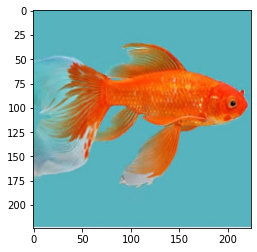

In [15]:
image = preprocess_input_by_filename( image_path)

In [16]:
model = load_model()
optimizer = Adam(learning_rate=LR)
sccLoss = SparseCategoricalCrossentropy()

In [17]:
baseImage = tf.constant(image, dtype=tf.float32)
delta = tf.Variable( tf.zeros_like(baseImage), trainable=True)

print("\nProcessing Perturbation\n")
deltaUpdated = generate_adversaries(model, baseImage, delta, get_class_index(result[1]))


Processing Perturbation

step: 0, loss:-0.0001842805795604363 ...
step: 5, loss:-0.00023624490131624043 ...
step: 10, loss:-0.0003856868715956807 ...
step: 15, loss:-0.0007185738068073988 ...
step: 20, loss:-0.0017335877055302262 ...
step: 25, loss:-0.0072698346339166164 ...
step: 30, loss:-0.08161935210227966 ...
step: 35, loss:-0.910210132598877 ...
step: 40, loss:-3.10840106010437 ...
step: 45, loss:-5.658430099487305 ...


True

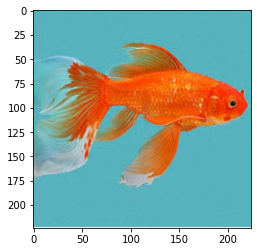

In [18]:
adversarial_image = (baseImage+deltaUpdated).numpy().squeeze()
adversarial_image = np.clip( adversarial_image, 0, 255).astype("uint8")
plt.imshow( adversarial_image)
adversarial_image = cv2.cvtColor( adversarial_image, cv2.COLOR_RGB2BGR)
cv2.imwrite("./output.jpg", adversarial_image)

# Prediction on Adversarial image

 Predicted image as :  hair_slide  with confidence :  0.4477853  and classIdx =  584


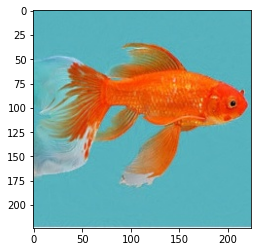

In [19]:
adversarial_image = preprocess_input_by_filename("./output.jpg")
result = predict( resnet, adversarial_image)
print(" Predicted image as : ", result[1], " with confidence : ", result[2], " and classIdx = ", get_class_index(result[1]))

# Noise Visualisation

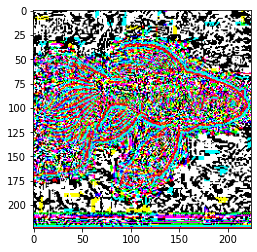

In [20]:
orig = preprocess_input_by_filename( image_path)
adversarial = preprocess_input_by_filename( "./output.jpg")
noise = adversarial - orig
plt.imshow( noise[0])